# Disciplina C318 - Data Science and Machine Learning Fundamentals
## Tema: Custo Médio de Tratamentos no Brasil


**Alunos:**
 - **Jônathan Stefan Covelo de Carvalho - GEC 1668**
 - **Letícia Vitória Merss Moreira - GES 56**
 - **Lívia Jacklinne Ramos Moreira - GEC 1731**

----------------------------------------------------------------------------------------------------------------


### **Step 1** : Importação de bibliotecas e frameworks

In [4]:
# Importando bibliotecas necessárias

import seaborn as sns
import pandas as pd
import pandas_gbq
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default='browser'
template = 'plotly' # "plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white"
import streamlit as st
import klib
import os
import tarfile
import urllib
import sklearn
import urllib.request
from   summarytools import dfSummary
from   zlib import crc32
from   pathlib import Path
from   google.cloud import bigquery
from   google.oauth2 import service_account
from   summarytools import dfSummary
from   sklearn.model_selection import train_test_split

### **Step 2** : Importação e informações sobre os dados

In [26]:
# Carregando o CSV
df = pd.read_csv('large_doencas_brasil.csv')

# Verificando as informações gerais do dataframe
df.info()

print('Estatísticas descritivas do dataframe')
df_describe = df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   nome_doenca                    20000 non-null  object 
 1   categoria                      20000 non-null  object 
 2   regiao_mais_afetada            20000 non-null  object 
 3   incidencia_anual_por_100k_hab  20000 non-null  int64  
 4   faixa_etaria_afetada           20000 non-null  object 
 5   mortalidade_%                  20000 non-null  float64
 6   numero_de_casos                20000 non-null  int64  
 7   tipo_de_tratamento             20000 non-null  object 
 8   custo_medio_tratamento_R$      20000 non-null  int64  
 9   duracao_media_tratamento_dias  20000 non-null  int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 1.5+ MB


### **Step 3** : Exploração inicial de dados

regiao_mais_afetada
Nordeste        4076
Sul             4037
Centro-Oeste    3989
Norte           3962
Sudeste         3936
Name: count, dtype: int64


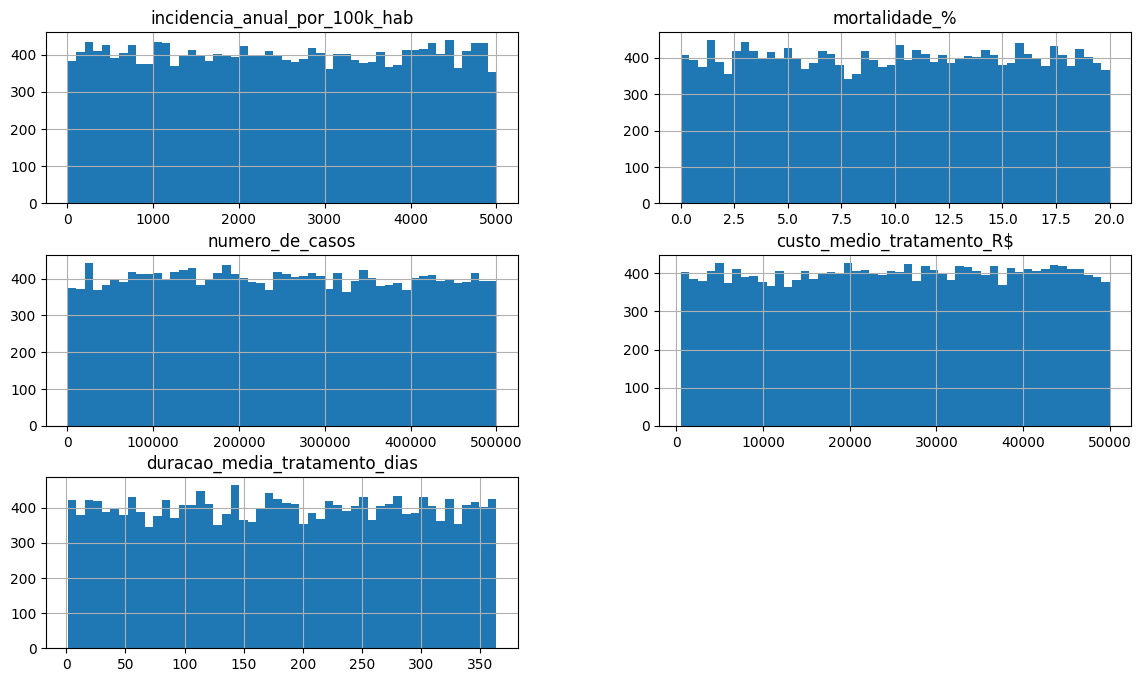

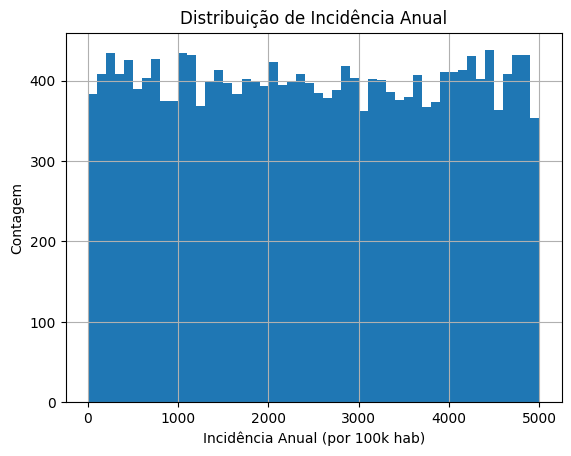

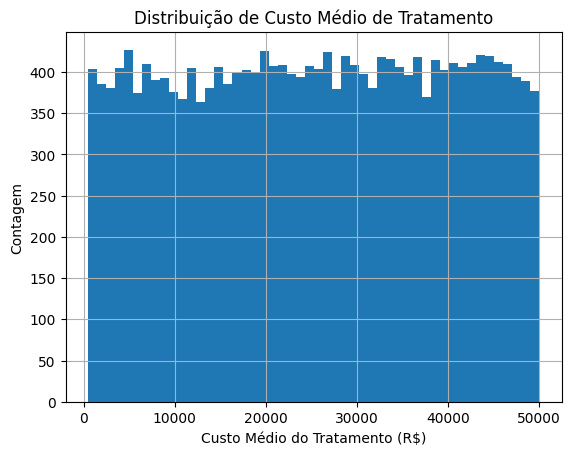

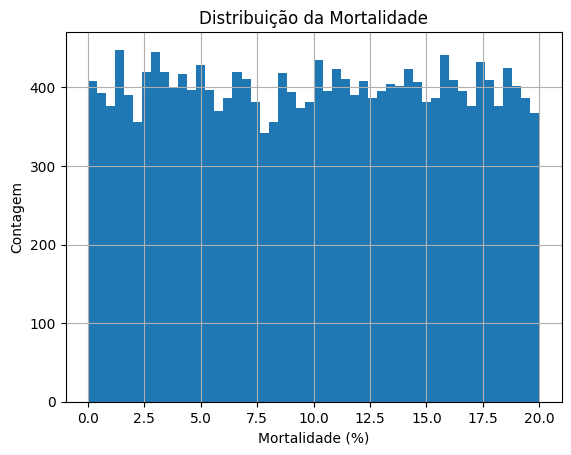

Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.
Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.
Large dataset detected, using 10000 random samples for the plots. Summary statistics are still based on the entire dataset.


<Axes: xlabel='mortalidade_%', ylabel='Density'>

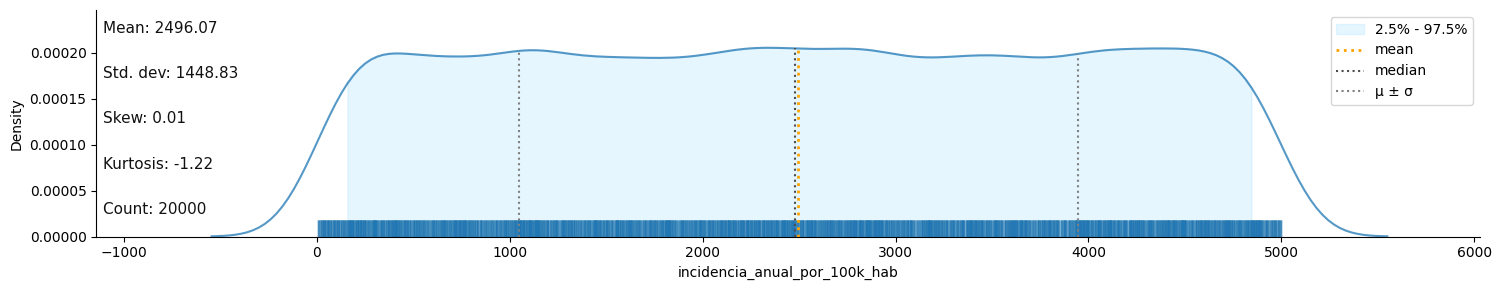

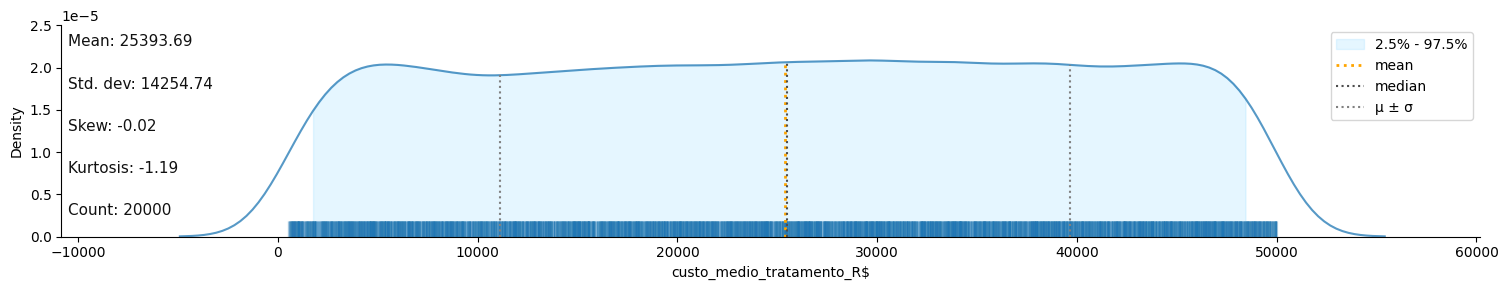

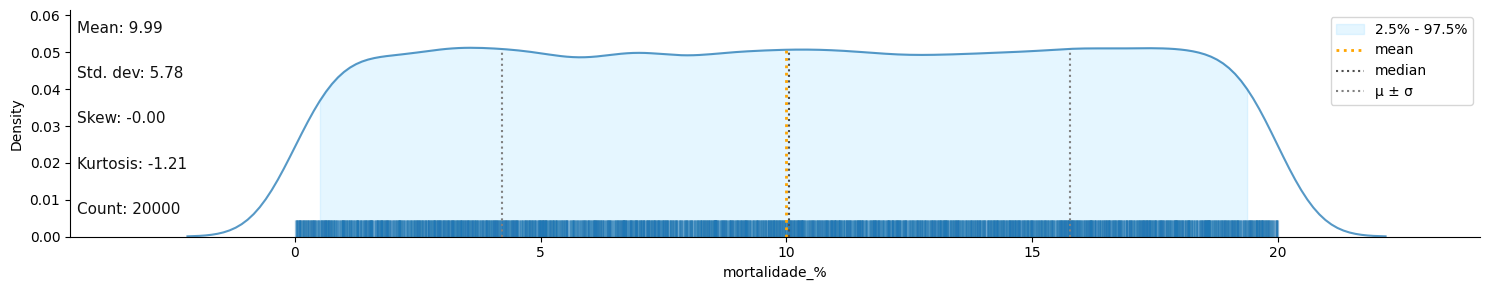

In [27]:
# Verificando a variável categórica - por exemplo, Região ou Tipo de Doença
categorical_column = 'regiao_mais_afetada'  # Ajustar o nome da coluna conforme o CSV
grupos = df[categorical_column].value_counts()
print(grupos)

# Visualizando histogramas de todas as variáveis do dataframe
df.hist(bins=50, figsize=(14,8))
plt.show()

# Visualizando histogramas de variáveis específicas
df['incidencia_anual_por_100k_hab'].hist(bins=50)
plt.xlabel('Incidência Anual (por 100k hab)')
plt.ylabel('Contagem')
plt.title('Distribuição de Incidência Anual')
plt.show()

df['custo_medio_tratamento_R$'].hist(bins=50)
plt.xlabel('Custo Médio do Tratamento (R$)')
plt.ylabel('Contagem')
plt.title('Distribuição de Custo Médio de Tratamento')
plt.show()

df['mortalidade_%'].hist(bins=50)
plt.xlabel('mortalidade_%')
plt.ylabel('Contagem')
plt.title('Distribuição da Mortalidade')
plt.show()

# Usando klib para visualizar distribuições mais detalhadas
klib.dist_plot(df['incidencia_anual_por_100k_hab'])
klib.dist_plot(df['custo_medio_tratamento_R$'])
klib.dist_plot(df['mortalidade_%'])

### **Step 4** : Métodos de amostragem

**Métodos de amostragem baseados em permutação**

In [15]:
# Criação de conjuntos de dados de treino e teste
def shuffle_and_split_data(df, test_ratio):
    np.random.seed(44)
    rand_indx  = np.random.permutation(len(df))  # criação de índices aleatórios (tamanho do df)
    test_size  = int(len(df) * test_ratio)       # tamanho do conjunto de teste
    test_indx  = rand_indx[0:test_size]          # índices do conjunto de teste
    train_indx = rand_indx[test_size:]           # índices do conjunto de treino    
    # Uso de índices para captura dos dados do df - formando treino/test set
    traning_set = df.iloc[train_indx]
    test_set    = df.iloc[test_indx]
    return traning_set, test_set

train_set, test_set = shuffle_and_split_data(df, 0.3)
len(train_set)
len(test_set)
test_set.head()

,nome_doenca,categoria,regiao_mais_afetada,incidencia_anual_por_100k_hab,faixa_etaria_afetada,mortalidade_%,numero_de_casos,tipo_de_tratamento,custo_medio_tratamento_R$,duracao_media_tratamento_dias
10498,Diabetes,Infecciosa,Norte,3522,Crianças,19.89,333580,Vacina,49117,185
9798,Hipertensão,Infecciosa,Sudeste,4470,Crianças,14.10,275216,Internação,49801,21
12826,Zika,Infecciosa,Centro-Oeste,4232,Adultos,12.05,485175,Vacina,11845,75
6298,Tuberculose,Crônica,Nordeste,282,Todas,17.07,17362,Mudança de Estilo de Vida,32169,64
19040,Tuberculose,Infecciosa,Centro-Oeste,4130,Crianças,4.41,257055,Internação,30073,70


-----------------------------------------------------------------------------------
**Método de amostragem baseado em identificadores únicos**

In [16]:
# Função checagem do conjunto de teste
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    # Captura de cada id do dataframe
    ids = data[id_column]
    # Checagem de cada id, de acordo com crc32
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    df_nTest = data.loc[~in_test_set]
    df_Test  = data.loc[in_test_set]
    return df_nTest, df_Test

df.index[100]
np.int64(df.index[100])
crc32(np.int64(df.index[100]))
2**32

# Geração de índice único no dataframe df (reset_index), incluindo coluna
df_id = df.reset_index()

# Usando a função split_train_test_by_id para geração do conjunto de teste com
# checagem a partir dos índices únicos adicionados ao dataframe
train_set_id, teste_set_id = split_data_with_id_hash(df_id, 0.2, 'index')
train_set_id
teste_set_id

,index,nome_doenca,categoria,regiao_mais_afetada,incidencia_anual_por_100k_hab,faixa_etaria_afetada,mortalidade_%,numero_de_casos,tipo_de_tratamento,custo_medio_tratamento_R$,duracao_media_tratamento_dias
2,2,Gripe,Infecciosa,Sul,2446,Adolescentes,9.92,429944,Mudança de Estilo de Vida,11315,242
5,5,Febre Amarela,Infecciosa,Sudeste,3177,Todas,6.03,370341,Vacina,40118,298
12,12,Gripe,Crônica,Norte,2205,Idosos,17.90,275806,Internação,47287,89
16,16,Zika,Crônica,Centro-Oeste,1901,Todas,17.40,224022,Internação,28920,94
23,23,Tuberculose,Crônica,Nordeste,1552,Adolescentes,19.31,183557,Vacina,35636,179
...,...,...,...,...,...,...,...,...,...,...,...
19980,19980,Dengue,Infecciosa,Norte,4727,Adultos,9.56,203518,Medicamentos,48431,322
19984,19984,Diabetes,Crônica,Norte,1226,Adultos,6.18,107994,Cirurgia,3255,39
19991,19991,Chikungunya,Crônica,Nordeste,4988,Todas,18.48,38255,Vacina,6173,347
19993,19993,Tuberculose,Crônica,Sul,4896,Adolescentes,4.14,324978,Internação,31409,80


-----------------------------------------------------------------------------------
**Métodos de amostragem aleatória com scikit-learn**

In [17]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)
train_set
test_set

,nome_doenca,categoria,regiao_mais_afetada,incidencia_anual_por_100k_hab,faixa_etaria_afetada,mortalidade_%,numero_de_casos,tipo_de_tratamento,custo_medio_tratamento_R$,duracao_media_tratamento_dias
10650,Dengue,Infecciosa,Centro-Oeste,4754,Adultos,17.01,166948,Vacina,7969,320
2041,HIV/AIDS,Crônica,Nordeste,1794,Idosos,17.53,90218,Vacina,45074,212
8668,Diabetes,Crônica,Sul,1624,Idosos,8.89,478415,Vacina,42221,201
1114,HIV/AIDS,Crônica,Sul,4276,Idosos,3.47,461495,Mudança de Estilo de Vida,11646,233
13902,HIV/AIDS,Crônica,Nordeste,591,Crianças,7.95,130735,Internação,26918,85
...,...,...,...,...,...,...,...,...,...,...
4073,Tuberculose,Infecciosa,Sul,4041,Adolescentes,19.38,499613,Medicamentos,11736,21
7442,Tuberculose,Crônica,Sul,2718,Crianças,16.69,301598,Mudança de Estilo de Vida,5434,294
9999,Hipertensão,Crônica,Nordeste,3655,Idosos,3.58,300532,Cirurgia,24548,364
1870,Febre Amarela,Infecciosa,Nordeste,3303,Todas,12.83,101464,Cirurgia,24283,34


-----------------------------------------------------------------------------------
**Método de amostragem aleatória baseados em estratificação**

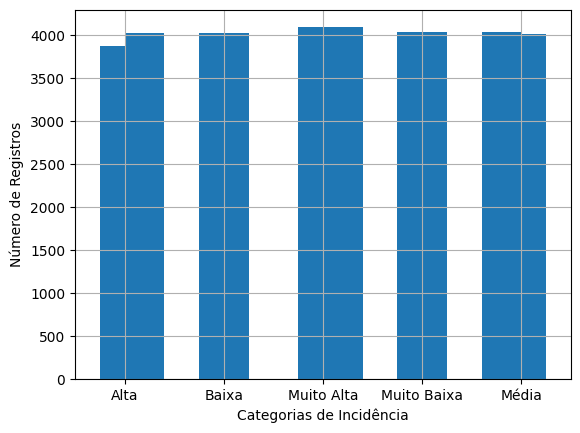

In [22]:
# Definir os limites dos estratos para a incidência anual por 100k habitantes
estratos_nomes = ['Muito Baixa', 'Baixa', 'Média', 'Alta', 'Muito Alta']
estratos_valores = [0, 1000, 2000, 3000, 4000, np.inf]

# Criar a coluna de categoria de incidência
df['incidencia_categorizada'] = pd.cut(df['incidencia_anual_por_100k_hab'],
                                       bins=estratos_valores,
                                       labels=estratos_nomes)

# Converter para tipo objeto
df['incidencia_categorizada'] = df['incidencia_categorizada'].astype(object)
df['incidencia_categorizada'].hist(bins = 10)

# Visualizar a distribuição dos estratos
df['incidencia_categorizada'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel('Categorias de Incidência')
plt.ylabel('Número de Registros')
# plt.show()

# Amostragem Estratificada com Sckit-Learn 
from sklearn.model_selection import StratifiedShuffleSplit

# Função StratifiedShuffleSplit - divisão aleatória por estratificação
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df, df['incidencia_categorizada']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]


-----------------------------------------------------------------------------------
**Métodos de amostragem aleatória baseados em estratificação**

In [23]:
# Proporção da variável categórica no conjunto de dados original
proportion_original_dataset = df['incidencia_categorizada'].value_counts()/len(df)

# Proporção - Amostragem aleatória simples - scikit-learn
random_train_set, random_test_set = train_test_split(df, test_size = 0.2, random_state = 42)
random_counts = random_test_set['incidencia_categorizada'].value_counts()
proportion_random_test = random_counts/len(random_test_set)

# Proporção - Amostragem aleatória estratficada - scikit-learn
strat_counts = strat_test_set['incidencia_categorizada'].value_counts()
proportion_strat_test = strat_counts/len(strat_test_set)

# Comparações de proporções (simples e estratificada em relação à proporção original)
print(proportion_original_dataset)
print(proportion_random_test)
print(proportion_strat_test)

incidencia_categorizada
Muito Alta     0.20430
Muito Baixa    0.20135
Baixa          0.20090
Média          0.20020
Alta           0.19325
Name: count, dtype: float64
incidencia_categorizada
Baixa          0.20750
Média          0.20100
Muito Baixa    0.19875
Muito Alta     0.19675
Alta           0.19600
Name: count, dtype: float64
incidencia_categorizada
Muito Alta     0.20425
Muito Baixa    0.20125
Baixa          0.20100
Média          0.20025
Alta           0.19325
Name: count, dtype: float64


### **Step 4** : Análise de dados - SQL Business Questions

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Defining features and target for cost prediction
X = df[['incidencia_anual_por_100k_hab', 'numero_de_casos', 'mortalidade_%']]
y = df['custo_medio_tratamento_R$']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 203534383.1042663


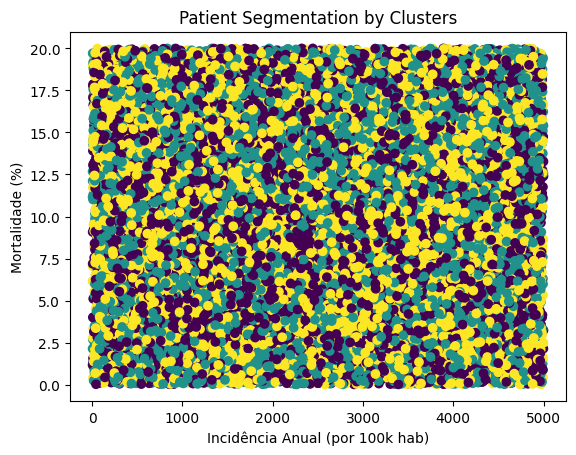

In [36]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Selecting features for clustering
X_clustering = df[['incidencia_anual_por_100k_hab', 'mortalidade_%', 'numero_de_casos']]

# Applying KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_clustering)

# Visualizing the clusters
plt.scatter(X_clustering.iloc[:, 0], X_clustering.iloc[:, 1], c=df['Cluster'], cmap='viridis')
plt.title('Patient Segmentation by Clusters')
plt.xlabel('Incidência Anual (por 100k hab)')
plt.ylabel('Mortalidade (%)')
plt.show()


In [33]:
# Grouping data by region and calculating total cases and costs
resource_allocation = df.groupby('regiao_mais_afetada').agg({
    'numero_de_casos': 'sum',
    'custo_medio_tratamento_R$': 'mean'
}).sort_values(by='numero_de_casos', ascending=False)

# Displaying the regions with the highest need for resources
resource_allocation.head()

,numero_de_casos,custo_medio_tratamento_R$
regiao_mais_afetada,,
Nordeste,1029380633,25246.620952
Sul,1004123648,25424.163240
Centro-Oeste,998063053,25149.271497
Norte,987734347,25310.889955
Sudeste,965234070,25845.775152


In [35]:
# Grouping data by treatment type and comparing efficacy
treatment_effectiveness = df.groupby('tipo_de_tratamento').agg({
    'incidencia_anual_por_100k_hab': 'mean',
    'mortalidade_%': 'mean'
}).sort_values(by='mortalidade_%')

# Displaying the effectiveness of treatments
treatment_effectiveness.head()

,incidencia_anual_por_100k_hab,mortalidade_%
tipo_de_tratamento,,
Medicamentos,2498.102005,9.805015
Mudança de Estilo de Vida,2481.772292,10.018368
Cirurgia,2511.984584,10.021645
Vacina,2507.896467,10.053874
Internação,2480.446718,10.063484
